# Calculate the nonstationary internal tide GP/spectral parameters

# Dask worker setup instructions

https://github.com/mrayson/pawsey-containers/tree/master/hpc-python/jupyter-sfoda

These settings do the job:

 1. `dask-scheduler --scheduler-file scheduler-$HOSTNAME.json --idle-timeout 0`
 2. `ssh localhost "cd /software/projects/pawsey0106/mrayson/projects && sbatch --time=04:00:00 --ntasks=64 -c 2 start_worker.slm scheduler-$HOSTNAME.json ./"`


In [25]:
hostname = !echo $(hostname)
hostname[0]

'nid001522'

In [26]:
import os
from distributed import Client
client=Client(scheduler_file='../../scheduler-' + hostname[0] + '.json')
client

<Client: 'tcp://10.253.131.7:8786' processes=0 threads=0, memory=0 B>

In [3]:
# Make sure the workers can see the paths
# https://distributed.dask.org/en/latest/plugins.html#distributed.diagnostics.plugin.UploadDirectory
# from distributed.diagnostics.plugin import UploadDirectory

# _=client.register_worker_plugin(UploadDirectory("/software/projects/pawsey0106/mrayson/projects/incoherentitide"), nanny=True) 

In [4]:
# client.restart() # This clears all data

In [27]:
import sfoda.suntans.sunxarray as sxr

import glob
import xarray as xr
import numpy as onp
import matplotlib.pyplot as plt
from cmocean import cm
from s3fs import S3FileSystem, S3Map

# from jax import numpy as np
# import jax 
# import optax
# import nonstat_itides_jax as nsjax # Cannot import this to workers :(

In [28]:
# from jax.interpreters import xla
# xla._xla_callable.cache_clear()
# loss._clear_cache()

In [52]:
from functools import partial
from jax import numpy as np
import jax 
import optax

###########################
# Speccy jax version
###########################
# Speccy jax stuff


def is_even(x):
    return x % 2 == 0

def n_freq(n):
    return int(np.floor(n/2))

def taus(n, delta):
    return delta * np.arange(n)

def fftshift(x):
    return np.fft.fftshift(x)

def fftfreq(n, delta):
    return fftshift(np.fft.fftfreq(n, delta))

def periodogram(ts, delta = 1, h = None):
    
    n = ts.size

    if h is not None:
        norm = np.sum(h**2)
        scale = np.sqrt(n/norm)
        ts = scale * h * ts

    dft = np.fft.fft(ts)/np.sqrt(n/delta)
    
    I = np.real(dft * np.conj(dft))
    ff = np.fft.fftfreq(n, delta)

    return fftshift(ff), fftshift(I)

def whittle(ts, specfunc, params, delta = 1, h = None):
    
    ff, I = periodogram(ts, delta, h)
    S = specfunc(ff, params)

    ll = - (np.log(S) + I/S)
    idx = (ff != 0) * (ff != -0.5/delta)
    
    return np.sum(ll[idx])

def dwhittle(ts, acffunc, params, delta = 1, h = None):
    
    tt = delta * np.arange(ts.size)
    ff, I = periodogram(ts, delta, h)
    ff_boch, S_boch = bochner(acffunc(tt, params), delta = delta, bias = True)
    # HACK: quick fix cause bochner isn't two sided yet
    return - 2 * np.sum(np.log(S_boch[ff_boch > 0]) + I[ff > 0]/S_boch[ff_boch > 0])

#@partial(jax.jit, static_argnums=(1,2,3))
def bochner(acf, delta = 1, bias = True, h = None):

    n = np.size(acf)

    if h is not None:
        
        norm = np.sum(h**2)
        h_conv = (np.convolve(h, h, mode = 'full')/norm)[(n-1):]
        acf = h_conv * acf

    elif bias:

        acf = (1 - np.arange(n)/n) * acf

    ff = fftfreq(n, delta)

    if is_even(n):
        acf = np.concatenate([np.array([acf[0]/2]), acf[1:(n-1)], np.array([acf[-1]/2])])
    else:
        acf = np.concatenate([np.array([acf[0]/2]), acf[1:n]])
    
    psd = 2 * delta * np.real(np.fft.fft(acf))

    return ff, fftshift(psd)

#################################
# Covariance models - Jax version
##################################

def logit(p, scale=1.):
    cff = 1/scale
    return np.log(p*cff/(1-p*cff))

def invlogit(x, scale=1.):
    return scale*np.exp(x)/(1+np.exp(x))

# Covariance kernels / ACFs
def calc_dist(x, xpr, eps=1e-14):
    dx2 = np.power(x-xpr, 2.)
    #dx2[dx2<eps] = eps
    #dx2 = dx2.at[dx2<eps].set(eps)
    dx2 = np.where(dx2 < eps, eps, dx2)
    return np.sqrt(dx2)

def cosine(x, xpr, l):
    """Cosine base function"""
    return np.cos(2*np.pi*np.abs(x-xpr)/l)


def gamma_exp(x, xpr, gam, l):
    """γ-exponential covariance function"""
    dx = calc_dist(x, xpr)
    return np.exp(-np.power(dx/l, gam))

def oscillate_1d_gammaexp(x, xpr, params):
    """
    1D Oscillatory kernel
    """
    eta, d, l, gam = params

    return eta**2 * gamma_exp(x, xpr, gam, d) * cosine(x, xpr, l)

def oscillate_fD2D1_gammaexp(x, xpr, params, 
                     f_cor=2,
                     lt =[ (0.5+0.517525050851839)/2, (0.9972695689985752+1.0758059026974014)/2],
                                 gam=1.5):

    eta1, d1, eta2, d2, eta3, d3 = params
    
    C = oscillate_1d_gammaexp(x, xpr, (eta1, d1, f_cor, gam))
    C += oscillate_1d_gammaexp(x, xpr, (eta2, d2, lt[0], gam))
    C += oscillate_1d_gammaexp(x, xpr, (eta3, d3, lt[1], gam))

    return C

def oscillate_D2D1_gammaexp(x, xpr, params, 
                     f_cor=2,
                     lt =[ (0.5+0.517525050851839)/2, (0.9972695689985752+1.0758059026974014)/2],
                                 gam=1.5):

    eta2, d2, eta3, d3 = params
    
    C = oscillate_1d_gammaexp(x, xpr, (eta2, d2, lt[0], gam))
    C += oscillate_1d_gammaexp(x, xpr, (eta3, d3, lt[1], gam))

    return C


def itide_meso_gammaexp(x, xpr, params, **kwargs):
    eta_m, l_m, gam_m, eta1, d1,  eta2, d2, eta3, d3 = params

    C = eta_m**2 * gamma_exp(x, xpr, gam_m, l_m)
    C += oscillate_fD2D1_gammaexp(x, xpr, (eta1, d1, eta2, d2, eta3, d3), **kwargs)
    return C

def itide_meso_nof_gammaexp(x, xpr, params, **kwargs):
    eta_m, l_m, gam_m, eta2, d2, eta3, d3 = params

    C = eta_m**2 * gamma_exp(x, xpr, gam_m, l_m)
    C += oscillate_D2D1_gammaexp(x, xpr, (eta2, d2, eta3, d3), **kwargs)
    return C

# def oscillate_D2D1_gammaexp(x, xpr, params, 
#                      lt =[ (0.5+0.517525050851839)/2, (0.9972695689985752+1.0758059026974014)/2]):

#     eta1, d1, eta2, d2, gam1, gam2, constant = params
    

#     C = oscillate_1d_gammaexp(x, xpr, (eta1, d1, lt[0], gam1))
#     C += oscillate_1d_gammaexp(x, xpr, (eta2, d2, lt[1], gam2))
    
#     #C[0] = C[0] + constant
#     C = C.at[0].add(constant)

#     return C

# def oscillate_D2D1_gammaexp_fixed(x, xpr, params, 
#                      lt =[ (0.5+0.517525050851839)/2, (0.9972695689985752+1.0758059026974014)/2],
#                                  gam1=1.5, gam2=1.5):

#     eta1, d1, eta2, d2, constant = params
    

#     C = oscillate_1d_gammaexp(x, xpr, (eta1, d1, lt[0], gam1))
#     C += oscillate_1d_gammaexp(x, xpr, (eta2, d2, lt[1], gam2))
    
#     #C[0] = C[0] + constant
#     C = C.at[0].add(constant)

#     return C

# def oscillate_fD2D1_gammaexp(x, xpr, params, 
#                      f_cor=2,
#                      lt =[ (0.5+0.517525050851839)/2, (0.9972695689985752+1.0758059026974014)/2],
#                                  gam=1.5):

#     eta1, d1, eta2, d2, eta3, d3 = params
    
#     C = oscillate_1d_gammaexp(x, xpr, (eta1, d1, f_cor, gam))
#     C += oscillate_1d_gammaexp(x, xpr, (eta2, d2, lt[0], gam))
#     C += oscillate_1d_gammaexp(x, xpr, (eta3, d3, lt[1], gam))

#     return C


# def itide_fD2D1_meso_gammaexp(x, xpr, params, **kwargs):
#     eta_m, l_m, gam_m, eta1, d1,  eta2, d2, eta3, d3 = params

#     C = eta_m**2 * gamma_exp(x, xpr, gam_m, l_m)
#     C += oscillate_fD2D1_gammaexp(x, xpr, (eta1, d1, eta2, d2, eta3, d3), **kwargs)
#     return C

# def itide_D2_meso_gammaexp(x, xpr, params, 
#                      lt = 0.5):

#     eta_m, l_m, gam_m, eta2, d2, gam1 = params
    
#     C = eta_m**2 * gamma_exp(x, xpr, gam_m, l_m)
#     C += oscillate_1d_gammaexp(x, xpr, (eta2, d2, lt, gam1))

#     return C

# def itide_D2_meso_gammaexp_fixed(x, xpr, params, 
#                      lt = 0.5, gam1 = 1.0):

#     eta_m, l_m, gam_m, eta2, d2 = params
    
#     C = eta_m**2 * gamma_exp(x, xpr, gam_m, l_m)
#     C += oscillate_1d_gammaexp(x, xpr, (eta2, d2, lt, gam1))

#     return C


# def itide_D2D1_meso_nof_gammaexp(x, xpr, params, **kwargs):
#     eta_m, l_m, gam_m, eta2, d2, eta3, d3 = params

#     C = eta_m**2 * gamma_exp(x, xpr, gam_m, l_m)
#     C += oscillate_D2D1_gammaexp(x, xpr, (eta2, d2, eta3, d3), **kwargs)
#     return C

#################################################
# Jax parameter estimation/optimisation routines
#################################################
# Transformation of optimiser parameters
class LogTransformer:
    def __init__(self,params):
        self.params = params

    def __call__(self):
        return np.log(self.params)
    
    def out(self, tparams):
        return np.exp(tparams)

class LinearTransformer:
    def __init__(self,params, scale=1., offset=0.):
        self.scale = scale
        self.offset = offset
        self.params = params

    def __call__(self):
        return (self.params-offset)/scale
    
    def out(self, tparams):
        return self.params*scale + offset

class CustomTransformer:
    def __init__(self,params):
        self.params = params

    def __call__(self):
        params_t = np.log(self.params)
        params_t = params_t.at[2].set(invlogit(self.params[2],scale=2))
        params_t = params_t.at[5].set(invlogit(self.params[5],scale=2))
        return params_t
        
    def out(self, tparams):
        params = np.exp(tparams)
        #params[2] = nsjax.logit(tparams[2],scale=2)
        #params[5] = nsjax.logit(tparams[5],scale=2)
        params = params.at[2].set(logit(tparams[2],scale=2))
        params = params.at[5].set(logit(tparams[5],scale=2))
        return params
        
###
# Loss functions
def dwhittle_fast(x, y, ff, I, acffunc, params, delta = 1, h = None, fmin=0, fmax=np.inf, acf_kwargs={}):
    ff_boch, S_boch = bochner(acffunc(x, x[0], params, **acf_kwargs), delta = delta, bias = True)
    # Subset frequencies
    idx = (ff > fmin) & (ff<fmax)
    whit = np.log(S_boch) + I/S_boch
    return -2* np.where(idx, whit, 0).sum()

#@partial(jax.jit, static_argnums=(5,6,7,8,9))
@jax.value_and_grad
@partial(jax.jit, static_argnums=(5,6,7,8,9))
def loss(logparams,  X, y, f, I, covfunc,  dt, fmin, fmax, Transformer, acf_kwargs):
    params = Transformer.out(logparams)
    return -dwhittle_fast(X, y, f, I, covfunc, params, delta=dt, fmin=fmin, fmax=fmax, acf_kwargs=acf_kwargs) 

#####
# Main optimisation routine
#####
def estimate_jax(y, X, covfunc, covparams_ic, fmin, fmax,
                 cov_kwargs={},
                window=None,
                verbose=True,
                maxiter=500,
                ftol=1e-2,
                opt= optax.sgd(learning_rate=3e-4),
                transformer=LogTransformer):

    dt = X[1]-X[0]
    f, I = periodogram(y, delta=dt, h=window)
    idx = (f > fmin) & (f<fmax)
    
    # def dwhittle_jax(params, acffunc):
    #     ff_boch, S_boch = bochner(acffunc(x, x[0], params))
    #     whit = np.log(S_boch) + I/S_boch
    #     return -2* np.where(idx, whit, 0).sum()
    
    # @jax.value_and_grad
    # @partial(jax.jit, static_argnums=(1))
    # def loss2(logparams, covfunc):
    #     params = np.exp(logparams)
    #     return -dwhittle_jax(params, covfunc) 

    T = transformer(np.array(covparams_ic))
    logparams = T()
    
    opt_state = opt.init(logparams)
    loss_val = np.inf
    for i in range(maxiter):
        
        loss_val_new, grads = loss(logparams, np.array(X), np.array(y), f, I, 
                                   covfunc,  dt, fmin, fmax, T, cov_kwargs)
        
        # jit is done here because of memory leak issues
        # See e.g.: https://github.com/google/jax/issues/2072
        #jit_loss = partial(jax.jit(loss, static_argnums=(5,6,7,8,9)) )
        #loss_val_new, grads = jit_loss(logparams, np.array(X), np.array(y), f, I, 
        #                           covfunc,  dt, fmin, fmax, T, cov_kwargs)
        
        #loss_val_new, grads = loss2(logparams, covfunc)
        updates, opt_state = opt.update(grads, opt_state)
        logparams = optax.apply_updates(logparams, updates)
        
        if i % 25 == 0:
            if verbose:
                print(f'step {i}, loss: {loss_val_new}')
                print(np.exp(logparams))
        if np.abs(loss_val_new-loss_val) < ftol:
            if verbose:
                print(f'step {i}, loss: {loss_val}')
            break
    
        loss_val = 1*loss_val_new
        
    # Trying to free memory
    jax.clear_caches()
    
    return T.out(logparams), loss_val
    #return np.concatenate([T.out(logparams), np.array([loss_val])])


In [44]:
s3login = '/home/mrayson/code/s3.acacia.login'

with open(s3login) as f:
    lines = f.readlines()

url, key, secret = [ff.strip('\n') for ff in lines[0:3]]
s3 = S3FileSystem(client_kwargs={'endpoint_url':url},
            key=key,
            secret=secret)


In [45]:
def save_load_chunk(ds, i1, i2, varname):
    
    tmpfile = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/tmp.zarr'
    
    y = ds[varname].\
        sel(time=slice('2013-07-15','2014-07-01')).isel(Nc=slice(i1, i2))#.chunk({'Nc':1})##.chunk({'Nc':1})
    X = (y.time-y.time[0]).values.astype(float)/1e9/86400

    dsout = xr.Dataset({'y':y}) #
    dsout
    dsout['y'].encoding['chunks']={'chunks':(8425,100) }
    dsout['y'].encoding['preferred_chunks']={'time': 8425, 'Nc': 100},
    dsout.to_zarr(tmpfile, compute=True, mode='w')

    # ds = xr.load_dataset(tmpfile, engine='zarr', chunks={}).chunk({'Nc':1}) # This loads the data?
    dsnew = xr.load_dataset(tmpfile, engine='zarr').chunk({'Nc':1})

    #y_ = da.from_zarr(tmpfile, component='y')
    
    return dsnew['y'], X, ds['yv'].isel(Nc=slice(i1, i2)).chunk({'Nc':100})



In [46]:
###
# Inputs
eta1 = 0.01
eta2 = 0.005
eta3 = 0.01
dt1 = 5.
dt2 = 2.0
dt3 = 2.

eta_m = 0.1
l_m = 0.1
gam_m = 0.5


fmin = 1e-3 
fmax = 2.5 #

# covfunc=itide_fD2D1_meso_gammaexp
# covparams = (eta_m, l_m, gam_m, eta1, dt1, eta2, dt2, eta3, dt3,)
# paramnames = ['η_m','τ_m','γ_m','η_f','τ_f','η_D2','τ_D2', 'η_D1','τ_D1', ]

covfunc=itide_meso_nof_gammaexp
covparams = (eta_m, l_m, gam_m, eta2, dt2, eta3, dt3,)
paramnames = ['η_m','τ_m','γ_m','η_D2','τ_D2', 'η_D1','τ_D1', ]

#invarname = 'eta'
invarname = 'vc'
#invarname = 'uc'

outfile = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_seasonaltides_meso_nofD2D1_{}.zarr'.format(invarname)
outfile_nc = '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_seasonaltides_meso_nofD2D1_{}.nc'.format(invarname)

zarrin = 'NWS_2km_GLORYS_2013_2014_{}_seasonaltides.zarr'.format(invarname)
varname = '{}_non_phase_locked'.format(invarname)
dropvars=['{}_non_phase_locked'.format(invarname),'{}_phase_locked'.format(invarname)]



#####


# Change notes:
 - 

In [47]:
f = S3Map("uwaoceanprocesses-suntans/"+zarrin, s3=s3)

ds = xr.open_dataset(f, engine='zarr', chunks={})

# These need filling in??
#ds.suntans.xv=ds.xv.values
#ds.suntans.yv=ds.yv.values

ds

<xarray.Dataset>
Dimensions:              (Nc: 225368, numsides: 8, Nk: 80, time: 8761,
                          Np: 454016)
Coordinates:
  * time                 (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-0...
    z_r                  (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
Dimensions without coordinates: Nc, numsides, Nk, Np
Data variables:
    cells                (Nc, numsides) int32 dask.array<chunksize=(2000, 8), meta=np.ndarray>
    dv                   (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    dz                   (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    nfaces               (Nc) int32 dask.array<chunksize=(2000,), meta=np.ndarray>
    vc_non_phase_locked  (time, Nc) float64 dask.array<chunksize=(8761, 2000), meta=np.ndarray>
    vc_phase_locked      (time, Nc) float64 dask.array<chunksize=(8761, 2000), meta=np.ndarray>
    xp                   (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    xv                   (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    yp                   (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    yv                   (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
Attributes:
    Author:       mrayson
    Description:  SUNTANS surface fields

In [48]:
def compute_f_cpd_inv(lat):
    f_cor = 4*np.pi/86400*np.sin(np.abs(lat)*np.pi/180)
    return 2*np.pi/f_cor/86400

def estimate_spectral_params_jax(y, lat, X=None, covfunc=None, covparams_ic=None, fmin=None, fmax=None):
    
    f_cor_cpd = compute_f_cpd_inv(lat)
    
    params, loss_val = estimate_jax(y, X, covfunc, covparams, fmin, fmax,
                         cov_kwargs={'f_cor':f_cor_cpd},
                          maxiter=500,
                         opt= optax.adabelief(learning_rate=1e-1),
                         verbose=False)
    jax.clear_caches()
    return params, np.array([loss_val])

In [53]:
# Loop through in chunks
step = 10000
mode='w'
append_dim = None


for ii in range(0, ds.dims['Nc'], step):
    i1 = ii
    i2 = ii+step
    if i2 > ds.dims['Nc']:
        i2 = ds.dims['Nc']
    print(i1,i2, ds.dims['Nc'])
    
    print('\tSubsetting the data...')
    y, X, lat = save_load_chunk(ds, i1, i2, varname)
    
    window=None
    #window=hann(X.shape[0]) 
    inputs = dict(X=X, covfunc=covfunc, covparams_ic=covparams, fmin=fmin, fmax=fmax)
    
    print('\tBuilding the dask graph...')

    params, loss_val = xr.apply_ufunc(estimate_spectral_params_jax,
                      y,
                      lat,
                      dask='parallelized',
                      kwargs=inputs,
                      output_dtypes=[y.dtype, y.dtype],
                      input_core_dims=(['time',],[]),
                      output_core_dims=(['params'],[]),
                      #output_sizes=,
                      dask_gufunc_kwargs={'output_sizes':{'params':len(covparams)}},
                      vectorize=True,
                     )
    
    
    print('\tComputing parameters...')
    params = params.compute()  
    jax.clear_caches()
    
    dsout = ds.drop_vars(dropvars).isel(Nc=slice(i1,i2))
    
    dsout['data'] = params.chunk({'Nc':2000})
    dsout['data'].attrs = {'long_name':'Estimated covariance model parameters','location':'face',
                                     'parameter names':paramnames,
                          'covariance function':covfunc.__name__,
                           'input file':zarrin} 
    
    # Include the coriolis term used for the covariance calculation
    dsout['f_cpd_inv'] = xr.DataArray(compute_f_cpd_inv(lat.values), dims=('Nc',),
                                 attrs={'long_name':'Inverse Coriolis frequency','units':'cpd'})
    
    # dsout = xr.Dataset({'data':params})
    print('\tSaving output...')
    dsout.to_zarr(outfile, mode=mode, append_dim=append_dim, compute=True)
    append_dim='Nc'
    mode='a'
    print('\t\tDone.')

    #break

0 10000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


Task exception was never retrieved
future: <Task finished name='Task-244026' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244027' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244028' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244047' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244048' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244049' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244068' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244069' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244070' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244089' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244090' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244091' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244110' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244111' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244112' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244131' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244132' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244133' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244152' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244153' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244154' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244173' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244174' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244175' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244194' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244195' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244196' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244216' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244217' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244218' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244237' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244238' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244239' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244259' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244260' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244261' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244280' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244281' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244282' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244301' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244302' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244303' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244322' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244323' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244324' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244343' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244344' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244345' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244364' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244365' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244366' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244385' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244386' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244387' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244406' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244407' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244408' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244427' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244428' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244429' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244448' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244449' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244450' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244470' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244471' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244472' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244492' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244493' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244494' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244514' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244515' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244516' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244535' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244536' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244537' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244558' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244559' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244560' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244580' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244581' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244582' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244601' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244602' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244603' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244622' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244623' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244624' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244643' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244644' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244645' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244664' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244665' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244666' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244685' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244686' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244687' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244706' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244707' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244708' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244727' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244728' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244729' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244748' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244749' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244750' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244770' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244771' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244772' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244791' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244792' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244793' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244812' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244813' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244814' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244833' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244834' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244835' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244855' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244856' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244857' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244877' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244878' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244879' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244899' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244900' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244901' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244920' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244921' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244922' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244941' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244942' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244943' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244962' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244963' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244964' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-244983' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244984' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-244985' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245004' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245005' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245006' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245025' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245026' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245027' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245046' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245047' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245048' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245069' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245070' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245071' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245090' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245091' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245092' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245111' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245112' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245113' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245133' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245134' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245135' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245154' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245155' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245156' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245175' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245176' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245177' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245198' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245199' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245200' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245219' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245220' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245221' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245240' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245241' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245242' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245261' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245262' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245263' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245282' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245283' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245284' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245303' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245304' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245305' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245324' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245325' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245326' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245345' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245346' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245347' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245366' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245367' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245368' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245387' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245388' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245389' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245408' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245410' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245411' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245430' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245431' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245432' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245451' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245452' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245453' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245472' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245473' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245474' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245493' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245494' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245495' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245514' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245515' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245516' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245535' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245536' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245537' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245556' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245557' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245558' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245577' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245578' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245579' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245598' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245599' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245600' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245620' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245621' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245622' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245642' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245643' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245644' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245663' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245664' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245665' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245684' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245685' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245686' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245706' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245707' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245708' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245727' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245728' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245729' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245748' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245749' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245750' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245769' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245770' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245771' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245791' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245792' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245793' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245812' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245813' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245814' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245833' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245834' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245835' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245855' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245856' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245857' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245876' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245877' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245878' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245897' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245898' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245899' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245918' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245919' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245920' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245939' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245940' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245941' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245960' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245961' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245962' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-245981' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245982' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-245983' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246002' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246003' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246004' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246023' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246024' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246025' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246044' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246045' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246046' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246065' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246066' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246067' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246086' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246087' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246088' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246108' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246109' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246110' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246130' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246131' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246132' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246151' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246152' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246153' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246172' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246173' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246174' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246193' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246194' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246195' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246214' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246215' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246216' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246235' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246236' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246237' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246256' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246257' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246258' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246277' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246278' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246279' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246298' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246299' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246300' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246319' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246320' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246321' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246341' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246342' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246343' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246363' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246364' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246365' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246384' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246385' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246386' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246406' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246407' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246408' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246427' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246428' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246429' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246449' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246450' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246451' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246470' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246471' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246472' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246493' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246494' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246495' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246515' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246516' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246517' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246536' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246537' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246538' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246557' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246558' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246559' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246578' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246579' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246580' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246599' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246600' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246601' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246620' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246621' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246622' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246642' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246643' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246644' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246663' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246664' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246665' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246684' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246685' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246686' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246705' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246706' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246707' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246726' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246727' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246728' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246748' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246749' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246750' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246770' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246771' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246772' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246791' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246792' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246793' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246812' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246813' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246814' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246833' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246834' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246835' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246854' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246855' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246856' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246875' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246876' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246877' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246898' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246899' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246900' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246920' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246921' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246922' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246941' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246942' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246943' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246962' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246963' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246964' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-246983' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246984' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-246985' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247004' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247005' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247006' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247025' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247026' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247027' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247046' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247047' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247048' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247067' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247068' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247069' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247088' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247089' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247090' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247110' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247111' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247112' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247133' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247134' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247135' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247154' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247155' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247156' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247175' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247176' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247177' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247196' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247197' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247198' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247217' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247218' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247219' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247239' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247240' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247241' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247260' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247261' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247262' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247282' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247283' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247284' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247304' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247305' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247307' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247326' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247327' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247328' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247347' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247348' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247349' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247368' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247369' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247370' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247389' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247390' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247391' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247410' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247411' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247412' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247431' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247432' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247433' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247452' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247453' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247454' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247473' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247474' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247475' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247494' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247495' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247496' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247515' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247516' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247517' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247536' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247537' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247538' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247557' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247558' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247559' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247578' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247579' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247580' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247599' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247600' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247601' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247620' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247621' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247622' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247641' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247642' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247643' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247662' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247663' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247664' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247683' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247684' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247685' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247704' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247705' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247706' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247726' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247727' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247728' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247747' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247748' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247749' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247768' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247769' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247770' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247790' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247792' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247793' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247814' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247815' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247816' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247835' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247836' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247837' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247856' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247857' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247858' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247877' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247878' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247879' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247898' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247899' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247900' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247919' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247920' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247921' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247940' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247941' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247942' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247961' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247962' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247963' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-247982' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247983' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-247984' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248003' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248004' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248005' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248024' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248025' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248026' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248045' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248046' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248047' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248066' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248067' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248068' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248087' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248088' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248089' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248108' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248109' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248110' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248129' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248130' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248131' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248151' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248152' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248153' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248172' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248173' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248174' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248193' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248194' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248195' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248214' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248215' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248216' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248235' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248236' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248237' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248256' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248257' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248258' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248277' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248278' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248279' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248298' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248299' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248300' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248319' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248320' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248321' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248340' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248341' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248342' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248361' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248362' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248363' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248382' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248383' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248384' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248405' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248406' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248407' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248427' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248428' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248429' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248448' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248449' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248450' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248469' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248470' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248471' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248490' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248491' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248492' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248511' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248512' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248513' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248532' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248533' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248534' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248554' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248555' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248556' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248575' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248576' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248577' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248597' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248598' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248599' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248618' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248619' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248620' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248639' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248640' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248641' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248660' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248661' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248662' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248681' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248682' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248683' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248702' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248703' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248704' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248723' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248724' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248725' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248744' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248745' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248746' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248765' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248766' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248767' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248786' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248787' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248788' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248807' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248808' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248809' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248828' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248829' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248830' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248849' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248850' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248851' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248870' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248871' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248872' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248891' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248892' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248893' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248912' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248913' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248914' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248933' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248934' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248935' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248954' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248955' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248956' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248977' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248978' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248979' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-248998' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-248999' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249000' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249019' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249020' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249021' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249041' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249042' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249043' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249062' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249063' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249064' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249086' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249087' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249088' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249108' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249109' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249110' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249129' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249130' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249131' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249150' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249151' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249152' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249171' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249172' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249173' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249192' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249193' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249194' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249213' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249214' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249215' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249234' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249235' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249236' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249255' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249256' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249257' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249276' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249277' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249278' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249297' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249298' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249299' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249318' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249319' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249320' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249339' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249340' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249341' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249360' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249361' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249362' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249381' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249382' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249383' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249403' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249404' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249405' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249424' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249425' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249426' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249447' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249448' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249449' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249468' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249469' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249470' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249489' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249490' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249491' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249510' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249511' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249512' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249532' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249533' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249534' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249554' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249555' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249556' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249576' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249577' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249578' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249597' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249598' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249599' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249618' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249619' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249620' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249639' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249640' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249641' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249660' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249661' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249662' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249682' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249683' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249684' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249703' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249704' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249705' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249724' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249725' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249726' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249745' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249746' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249747' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249766' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249767' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249768' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249787' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249788' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249789' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249808' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249809' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249810' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249829' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249830' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249831' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249850' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249851' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249852' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249871' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249872' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249873' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249892' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249893' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249894' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249913' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249914' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249915' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249934' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249935' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249936' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249955' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249956' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249957' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249976' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249977' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249978' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-249997' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-249999' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250000' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250019' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250020' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250021' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250040' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250041' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250042' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250061' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250062' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250063' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250082' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250083' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250084' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250103' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250104' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250105' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250124' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250125' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250126' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250145' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250146' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250147' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250166' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250167' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250168' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250188' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250189' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250191' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250211' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250212' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250213' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250232' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250233' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250234' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250253' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250254' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250255' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250274' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250275' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250276' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250295' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250296' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250297' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250316' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250317' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250318' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250337' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250338' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250339' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250358' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250359' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250360' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250380' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250381' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250382' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250401' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250402' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250403' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250422' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250423' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250424' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250443' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250444' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250445' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250464' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250465' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250466' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250485' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250486' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250487' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250506' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250507' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250509' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250529' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250530' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250532' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250552' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250553' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250554' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250574' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250575' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250576' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250595' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250596' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250597' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250616' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250617' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250618' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250637' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250638' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250639' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250658' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250659' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250660' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250679' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250680' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250681' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250700' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250701' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250702' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250721' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250722' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250723' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250742' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250743' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250745' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250764' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250765' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250766' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250785' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250786' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250787' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250806' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250807' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250808' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250827' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250828' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250829' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250848' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250849' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250850' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250869' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250870' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250871' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250890' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250891' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250892' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250912' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250913' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250914' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250933' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250934' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250935' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250954' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250955' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250956' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250975' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250976' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250977' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-250996' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250997' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-250998' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251017' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251018' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251019' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251038' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251039' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251040' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251059' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251060' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251061' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251080' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251081' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251082' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251101' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251102' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251103' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251122' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251123' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251124' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251143' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251144' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251145' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251164' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251165' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251166' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251185' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251186' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251187' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251206' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251207' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251208' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251227' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251228' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251229' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251248' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251249' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251250' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251269' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251270' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251271' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251290' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251291' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251292' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251311' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251312' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251313' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251332' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251333' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251334' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251353' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251354' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251355' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251374' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251375' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251376' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251395' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251396' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251397' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251417' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251418' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251419' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251439' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251440' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251441' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251460' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251461' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251462' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251481' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251482' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251483' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251502' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251503' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251504' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251523' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251524' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251525' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251544' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251545' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251546' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251565' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251566' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251567' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251586' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251587' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251588' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251607' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251608' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251609' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251628' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251629' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251630' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251649' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251650' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251651' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251670' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251671' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251672' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251691' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251692' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251693' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251712' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251713' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251714' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251734' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251735' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251736' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251756' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251757' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251758' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251777' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251779' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251780' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251799' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251800' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251801' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251820' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251821' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251822' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251841' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251842' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251843' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251862' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251863' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251864' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251883' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251884' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251885' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251904' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251905' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251906' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251925' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251926' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251927' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251946' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251947' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251948' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251967' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251968' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251969' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-251989' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251990' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-251991' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252010' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252011' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252012' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252033' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252034' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252035' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252056' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252057' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252058' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252078' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252079' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252080' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252099' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252100' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252101' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252120' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252121' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252122' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252141' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252142' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252143' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252162' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252163' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252164' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252183' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252184' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252185' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252205' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252206' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252207' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252226' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252227' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252228' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252248' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252249' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252250' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252269' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252270' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252271' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252290' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252291' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252292' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252311' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252312' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252313' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252332' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252333' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252334' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252353' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252354' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252355' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252374' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252375' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252376' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252396' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252397' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252398' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252417' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252418' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252419' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252438' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252439' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252440' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252459' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252460' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252461' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252481' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252482' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252483' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252502' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252503' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252504' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252523' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252524' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252525' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252544' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252545' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252546' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252565' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252566' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252567' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252586' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252587' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252588' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252607' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252608' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252609' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252629' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252630' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252631' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252650' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252651' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252652' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252671' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252672' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252673' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252692' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252693' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252694' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252714' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252715' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252716' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252735' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252736' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252737' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252756' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252757' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252758' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252777' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252778' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252779' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252798' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252799' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252800' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252819' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252820' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252821' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252841' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252842' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252843' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252862' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252863' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252864' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252883' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252884' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252885' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252904' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252905' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252906' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252925' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252926' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252927' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252946' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252947' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252948' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252967' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252968' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252969' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-252988' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252989' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-252990' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253009' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253010' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253011' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253031' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253032' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253033' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253052' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253053' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253054' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253073' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253074' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253075' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253095' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253096' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253097' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253116' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253117' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253118' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253137' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253138' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253139' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253158' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253159' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253160' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253180' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253181' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253182' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253201' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253202' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253203' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253222' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253223' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253224' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253243' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253244' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253245' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253264' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253265' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253266' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253285' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253286' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253287' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253306' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253307' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253308' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253327' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253328' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253329' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253348' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253349' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253350' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253369' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253370' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253371' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253390' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253391' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253392' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253412' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253413' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253414' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253434' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253435' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253437' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253456' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253457' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253458' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253479' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253480' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253481' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253500' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253501' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253502' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253521' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253522' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253523' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253542' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253543' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253544' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253563' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253564' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253565' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253584' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253585' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253586' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253605' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253606' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253607' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253626' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253627' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253628' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253647' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253648' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253649' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253668' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253669' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253670' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253689' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253690' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253691' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253710' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253711' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253712' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253731' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253732' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253733' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253753' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253754' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253755' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253774' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253775' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253776' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253795' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253796' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253797' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253817' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253818' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253819' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253839' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253840' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253841' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253861' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253862' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253863' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253882' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253883' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253884' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253903' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253904' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253905' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253924' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253925' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253926' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253945' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253946' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253947' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253966' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253967' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253968' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-253987' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253988' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-253989' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

Task exception was never retrieved
future: <Task finished name='Task-254008' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-254009' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllExit()>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/client.py", line 2239, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-254010' coro=<Client._gather.<locals>.wait() done, defined at /opt/conda/lib/python3.10/site-packages/distributed/client.py:2230> exception=AllEx

	Saving output...
		Done.
10000 20000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 646.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
20000 30000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 646.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
30000 40000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 646.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
40000 50000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 646.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
50000 60000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 646.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
60000 70000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 646.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
70000 80000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 646.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
80000 90000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 646.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
90000 100000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 646.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
100000 110000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 646.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
110000 120000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 646.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
120000 130000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 646.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
130000 140000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 646.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
140000 150000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 646.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
150000 160000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 646.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
160000 170000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 646.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
170000 180000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 646.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
180000 190000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 646.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
190000 200000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 646.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
200000 210000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 646.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.
210000 220000 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 646.78 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2023-08-31 12:59:39,983 - distributed.client - WARNING - Couldn't gather 5 keys, rescheduling ("('transpose-de64fb80d45e2e555c5e8d2855a59226', 3391, 0)", "('transpose-de64fb80d45e2e555c5e8d2855a59226', 9325, 0)", "('transpose-de64fb80d45e2e555c5e8d2855a59226', 5528, 0)", "('transpose-de64fb80d45e2e555c5e8d2855a59226', 9029, 0)", "('transpose-de64fb80d45e2e555c5e8d2855a59226', 3646, 0)")


	Saving output...
		Done.
220000 225368 225368
	Subsetting the data...
	Building the dask graph...
	Computing parameters...


/opt/conda/lib/python3.10/site-packages/distributed/client.py:3160: UserWarning: Sending large graph of size 347.20 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


	Saving output...
		Done.


In [54]:
outfile, outfile_nc

('/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_seasonaltides_meso_nofD2D1_vc.zarr',
 '/scratch/pawsey0106/mrayson/SUNTANS_NWS_2km/NWS_2km_GLORYS_nonstat_itide_params_seasonaltides_meso_nofD2D1_vc.nc')

In [55]:
dsnew = xr.open_dataset(outfile, engine='zarr')

dsnew.to_netcdf(outfile_nc)
dsnew


<xarray.Dataset>
Dimensions:    (Nc: 225368, numsides: 8, params: 7, Nk: 80, time: 8761,
                Np: 454016)
Coordinates:
  * time       (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-07-01
    z_r        (Nk) float64 ...
Dimensions without coordinates: Nc, numsides, params, Nk, Np
Data variables:
    cells      (Nc, numsides) int32 ...
    data       (Nc, params) float64 ...
    dv         (Nc) float64 ...
    dz         (Nk) float64 ...
    f_cpd_inv  (Nc) float32 ...
    nfaces     (Nc) int32 ...
    xp         (Np) float64 ...
    xv         (Nc) float64 ...
    yp         (Np) float64 ...
    yv         (Nc) float64 ...
Attributes:
    Author:       mrayson
    Description:  SUNTANS surface fields

In [56]:
%matplotlib notebook

<IPython.core.display.Javascript object>


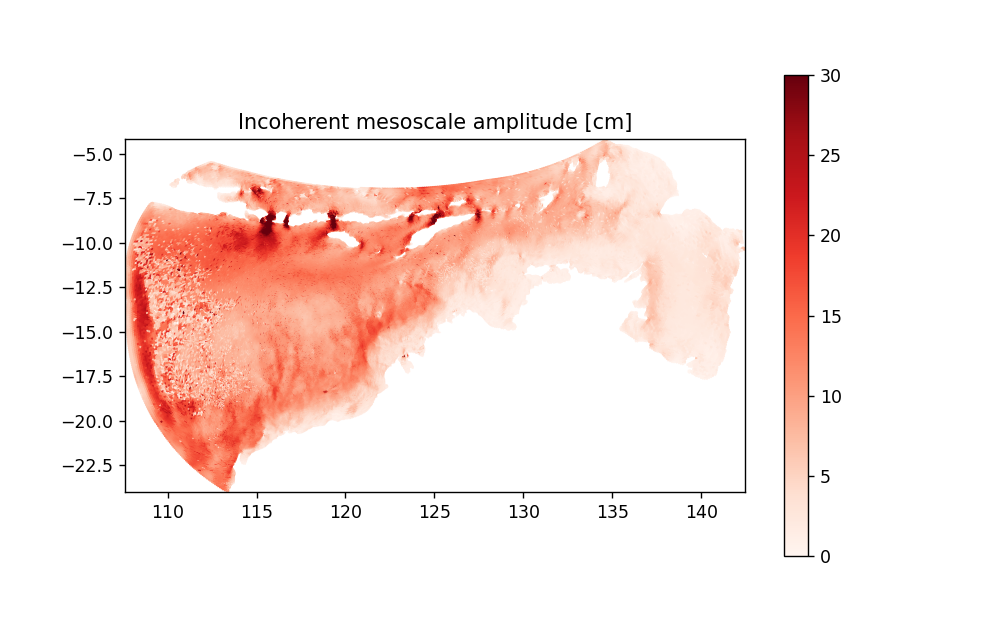

Changing the _FillValue from -999999 to 999999


Text(0.5, 1.0, 'Incoherent mesoscale amplitude [cm]')

In [57]:
plt.figure(figsize=(8,5))
# dsnew.suntans.plotcelldata(np.exp(dsnew['data'].isel(params=0))*1e4, cmap='Reds', vmin=0,vmax=200)
dsnew.suntans.plotcelldata((dsnew['data'].isel(params=0))*100, cmap='Reds', vmin=0,vmax=30)

plt.title('Incoherent mesoscale amplitude [cm]')

<IPython.core.display.Javascript object>


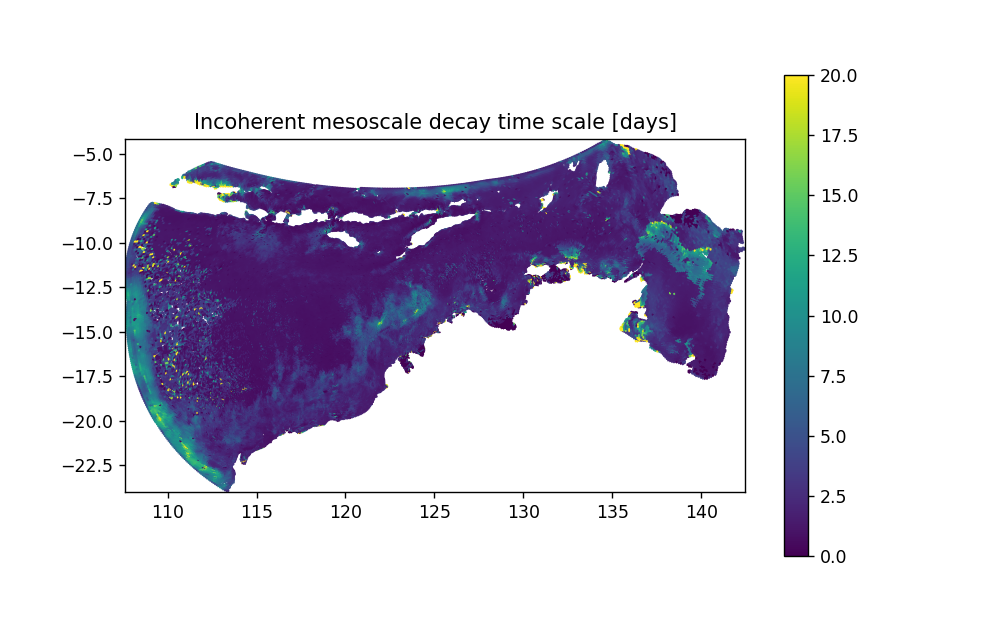

Text(0.5, 1.0, 'Incoherent mesoscale decay time scale [days]')

In [58]:
plt.figure(figsize=(8,5))
# dsnew.suntans.plotcelldata(np.exp(dsnew['data'].isel(params=1)), cmap='viridis', vmin=0, vmax=40)
dsnew.suntans.plotcelldata((dsnew['data'].isel(params=1)), cmap='viridis', vmin=0, vmax=20)

plt.title('Incoherent mesoscale decay time scale [days]')

<IPython.core.display.Javascript object>


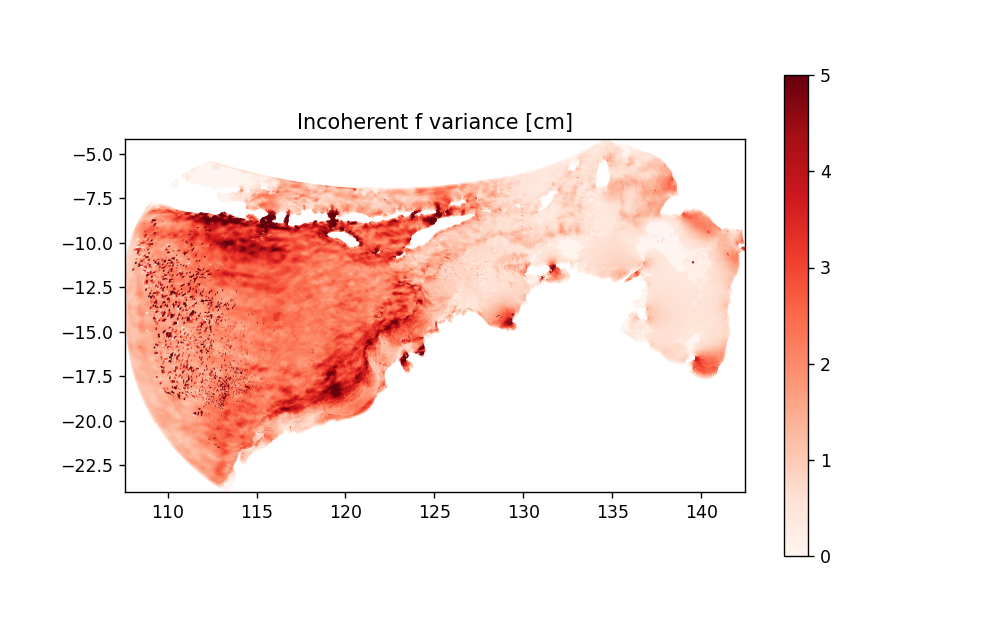

Text(0.5, 1.0, 'Incoherent f variance [cm]')

In [59]:
plt.figure(figsize=(8,5))
dsnew.suntans.plotcelldata((dsnew['data'].isel(params=3))*100, cmap='Reds', vmin=0.,vmax=5)
# dsnew.suntans.plotcelldata(np.abs(dsnew['data'].isel(params=2))*1e4, cmap='Reds', vmax=200)

plt.title('Incoherent f variance [cm]')

<IPython.core.display.Javascript object>


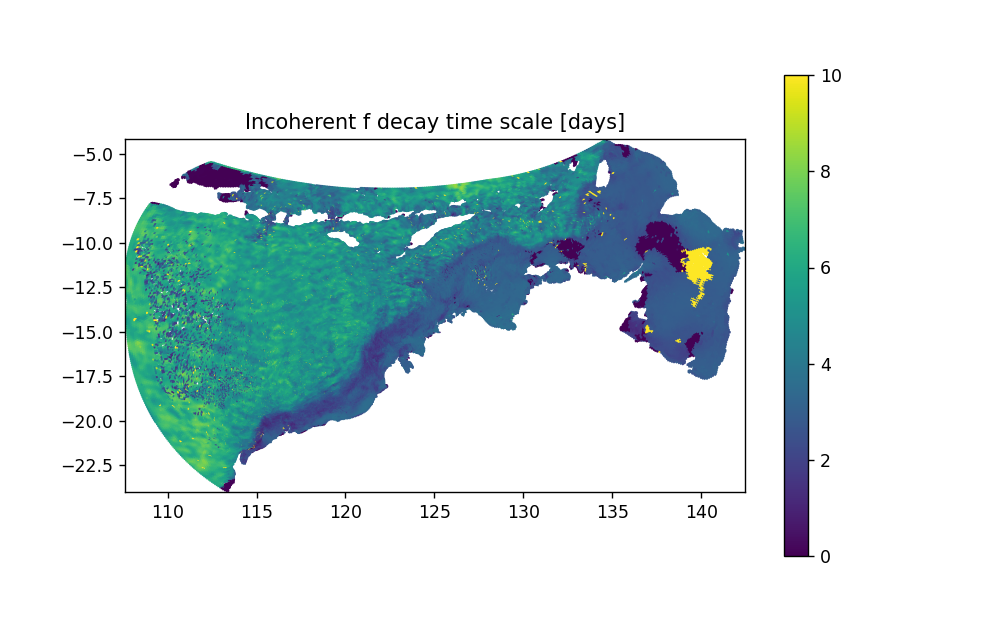

Text(0.5, 1.0, 'Incoherent f decay time scale [days]')

In [60]:
plt.figure(figsize=(8,5))
dsnew.suntans.plotcelldata((dsnew['data'].isel(params=4)), cmap='viridis', vmin=0, vmax=10)
plt.title('Incoherent f decay time scale [days]')

<IPython.core.display.Javascript object>


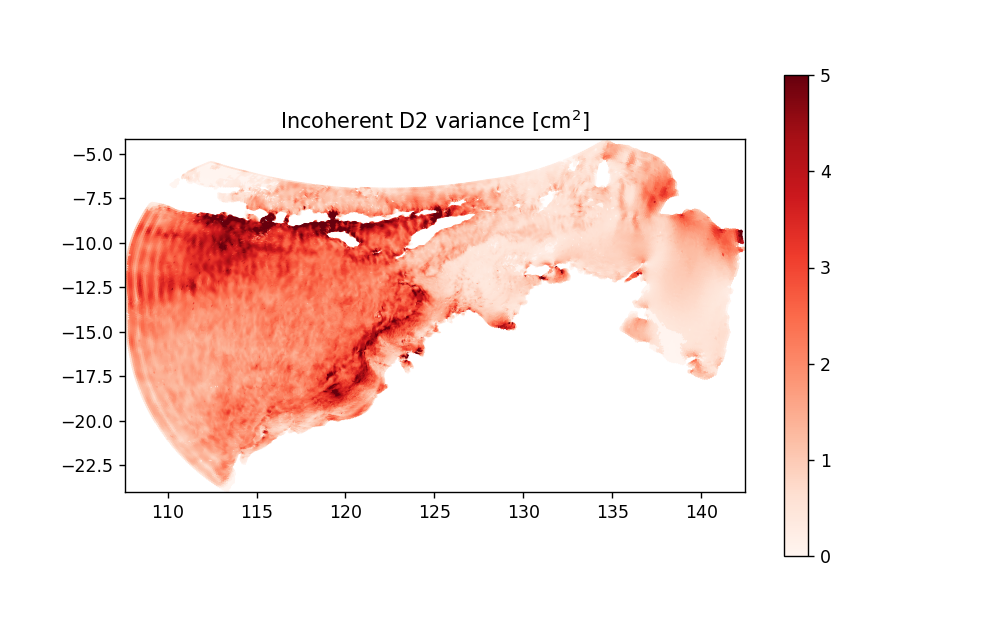

Text(0.5, 1.0, 'Incoherent D2 variance [cm$^2$]')

In [21]:
plt.figure(figsize=(8,5))
dsnew.suntans.plotcelldata((dsnew['data'].isel(params=5))*100, cmap='Reds', vmin=0.,vmax=5)
# dsnew.suntans.plotcelldata(np.abs(dsnew['data'].isel(params=2))*1e4, cmap='Reds', vmax=200)

plt.title('Incoherent D2 variance [cm$^2$]')

<IPython.core.display.Javascript object>


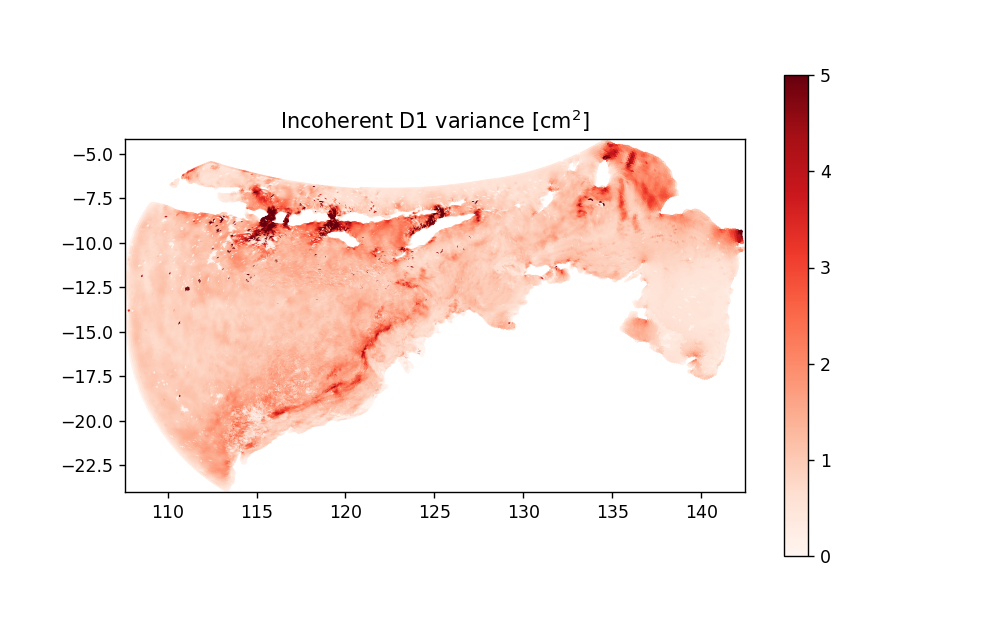

Text(0.5, 1.0, 'Incoherent D1 variance [cm$^2$]')

In [22]:
plt.figure(figsize=(8,5))
dsnew.suntans.plotcelldata((dsnew['data'].isel(params=7))*100, cmap='Reds', vmin=0.,vmax=5)
# dsnew.suntans.plotcelldata(np.abs(dsnew['data'].isel(params=2))*1e4, cmap='Reds', vmax=200)

plt.title('Incoherent D1 variance [cm$^2$]')

<IPython.core.display.Javascript object>


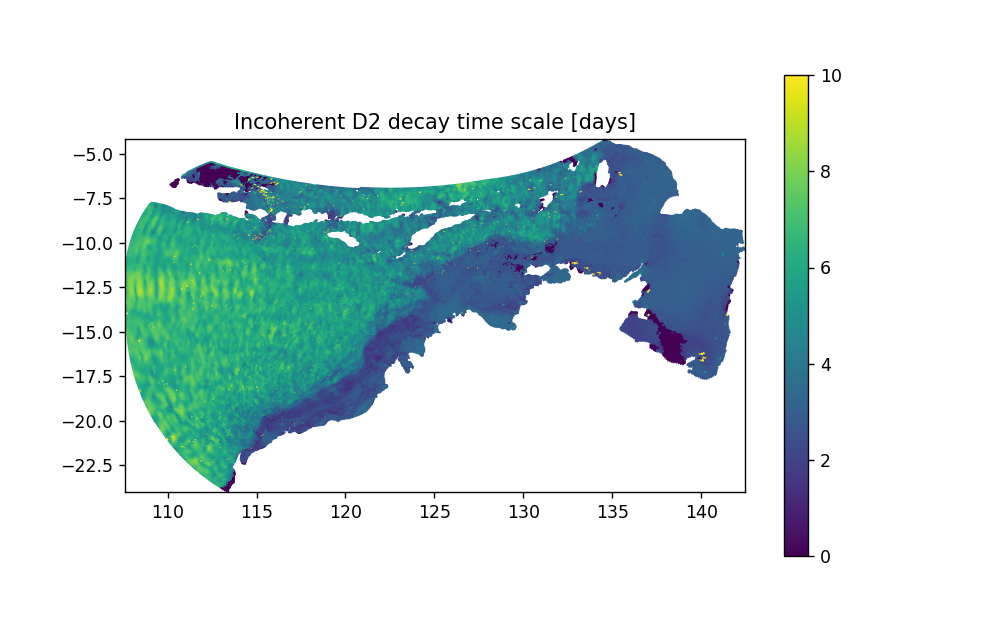

Text(0.5, 1.0, 'Incoherent D2 decay time scale [days]')

In [23]:
plt.figure(figsize=(8,5))
dsnew.suntans.plotcelldata((dsnew['data'].isel(params=6)), cmap='viridis', vmin=0, vmax=10)
plt.title('Incoherent D2 decay time scale [days]')

<IPython.core.display.Javascript object>


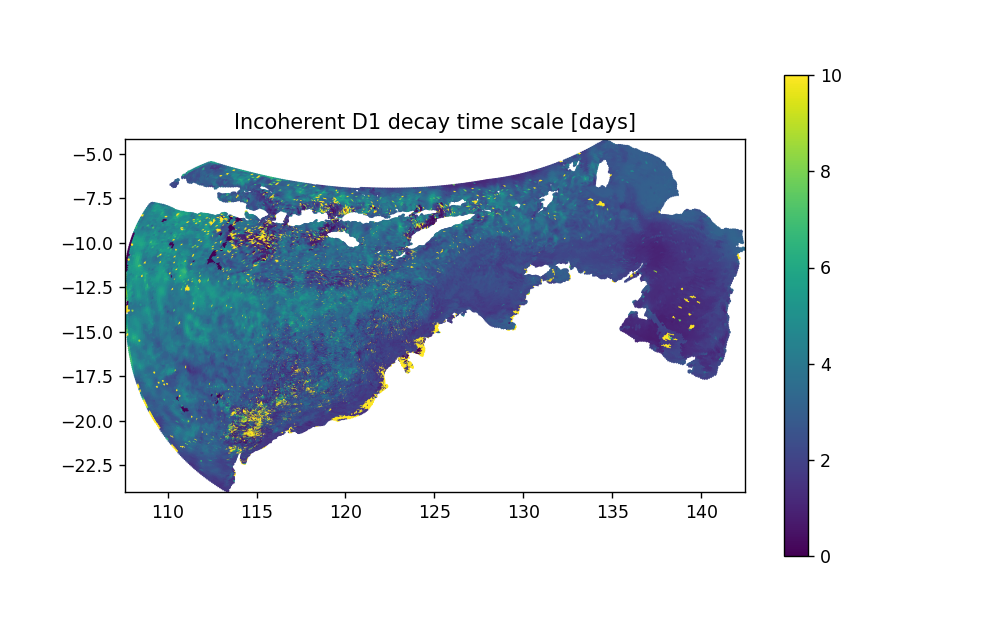

Text(0.5, 1.0, 'Incoherent D1 decay time scale [days]')

In [24]:
plt.figure(figsize=(8,5))
dsnew.suntans.plotcelldata((dsnew['data'].isel(params=8)), cmap='viridis', vmin=0, vmax=10)
plt.title('Incoherent D1 decay time scale [days]')